In [525]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import (
    DecisionTreeClassifier, 
    plot_tree
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay
)
from sklearn.svm import SVC

sns.set_style("ticks")
sns.set_context("paper")


## Loading data

In [526]:
wine_red = pd.read_csv('winequality-red.csv', sep=';')
wine_white = pd.read_csv('winequality-white.csv', sep=';')

## Data Treatment

### Creating a new column for opinion based on quality. This will be used as classifier for our Logistic Regression Model

In [527]:
def opinion(x):
    if x['quality']<=5:
        return 0
    else:
        return 1

wine_red['opinion']  = wine_red.apply(lambda x: opinion(x), axis=1)
wine_white['opinion']= wine_white.apply(lambda x: opinion(x), axis=1)

### Generating basic Dataframe analysis to assure the data is ready for training.

In [528]:
def get_info(wine_data):
    print(F'Column Names')
    print(wine_data.columns.values)
    print('DATA INFO: ')
    wine_data.info()
    print('DATA DESCRIPTION: ')
    print(wine_data.describe())
    print('DATA DUPLICATES: ')
    print(wine_data[wine_data.duplicated()])
    print('DATA SORT: ')
    print(wine_data.nunique().sort_values())
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Plot bar chart for wine quality
    wine_data.quality.value_counts().sort_index().plot.bar(width=1, ax=axes[0])
    axes[0].set_xlabel('Wine Quality')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Wine Quality')

    # Plot bar chart for wine opinion
    wine_data.opinion.value_counts().sort_index().plot.bar(width=1, ax=axes[1])
    axes[1].set_xlabel('Opinion')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Wine Opinion')

    plt.tight_layout()

    # Plot heatmap of correlation matrix
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(wine_data.corr(), vmax=1, vmin=-1, annot=True, cmap="coolwarm", ax=ax)
    ax.set_title('Correlation Matrix')

    plt.tight_layout()
    plt.show()


Column Names
['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol' 'quality' 'opinion']
DATA INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality         

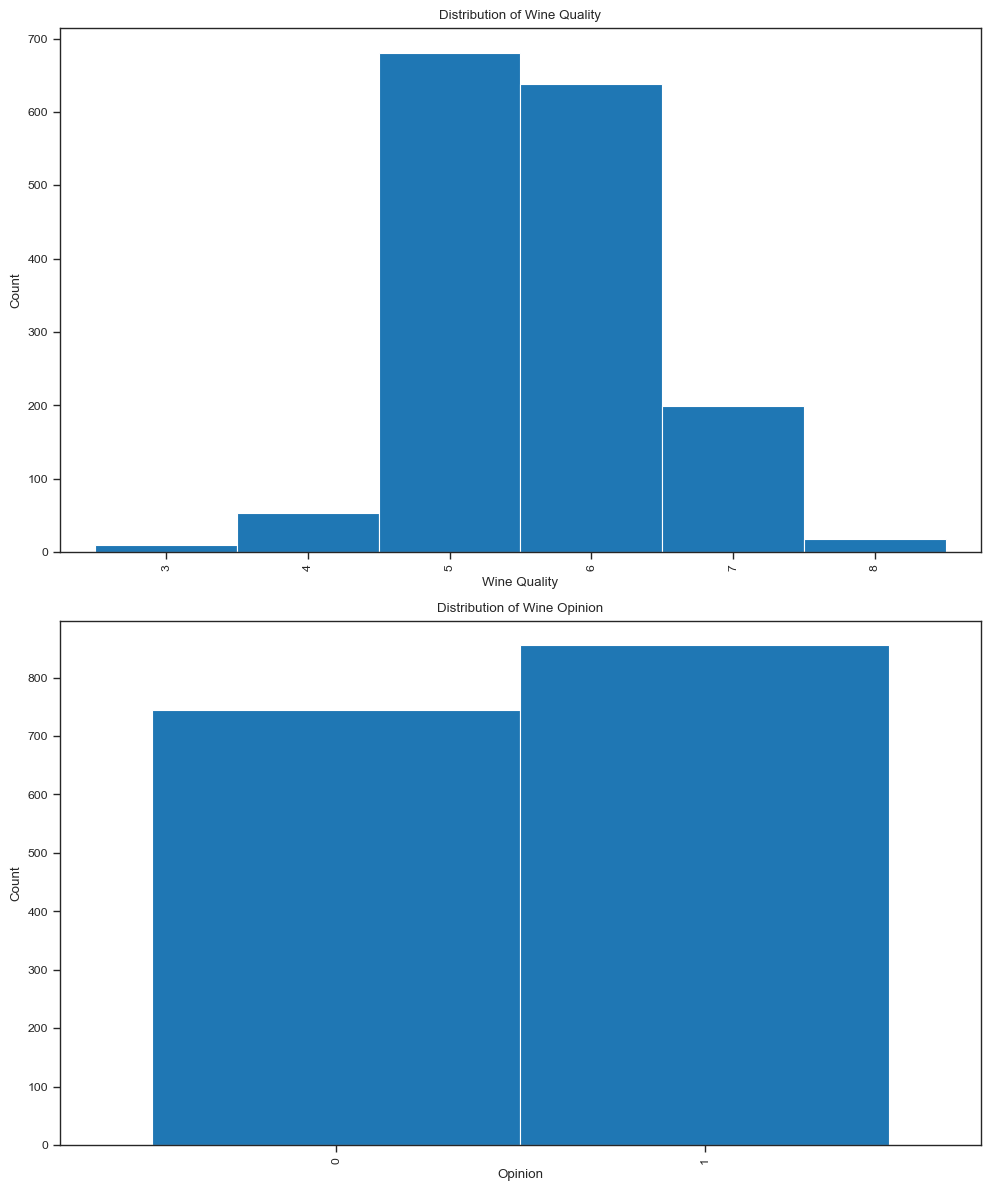

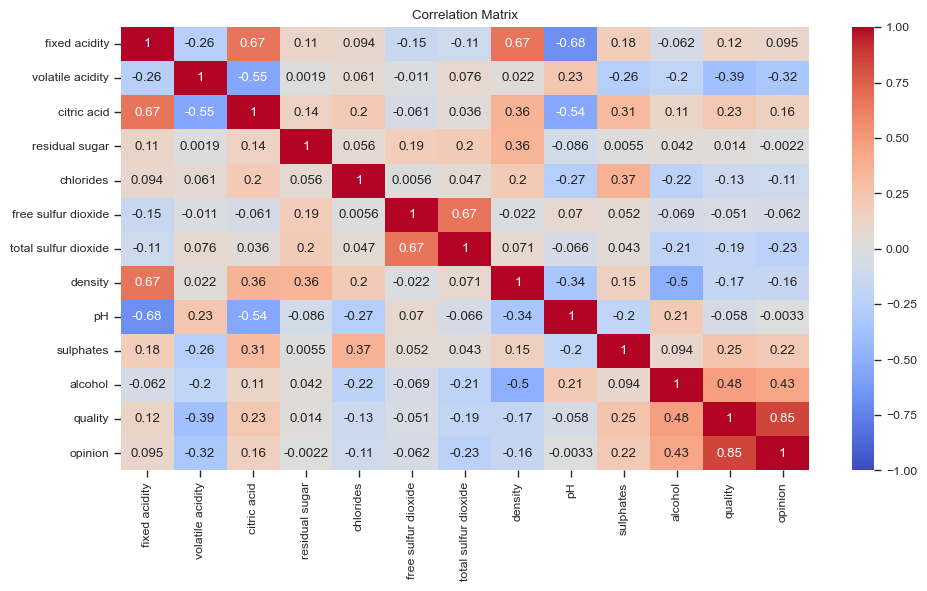

In [529]:
get_info(wine_red)

Column Names
['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol' 'quality' 'opinion']
DATA INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality         

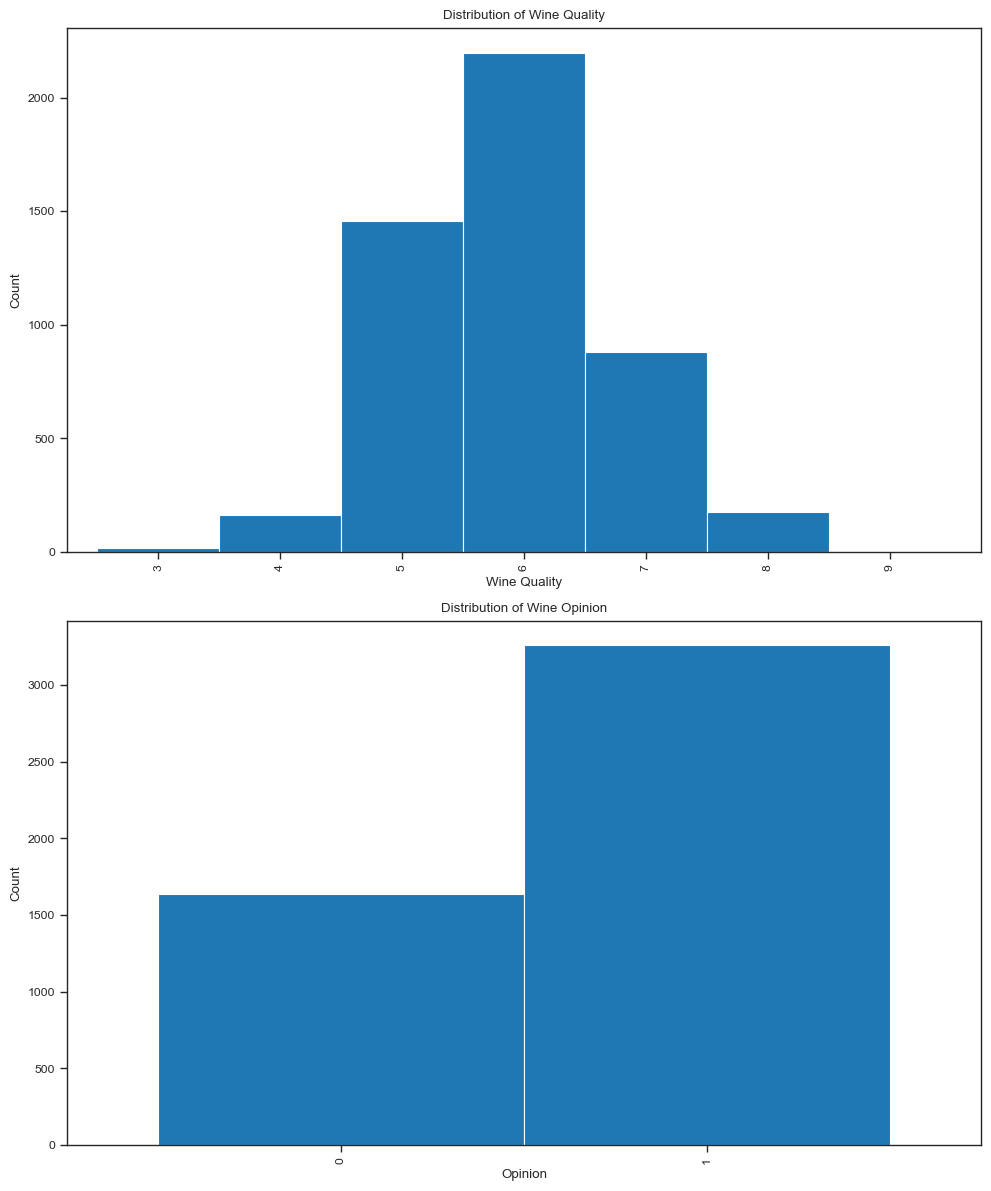

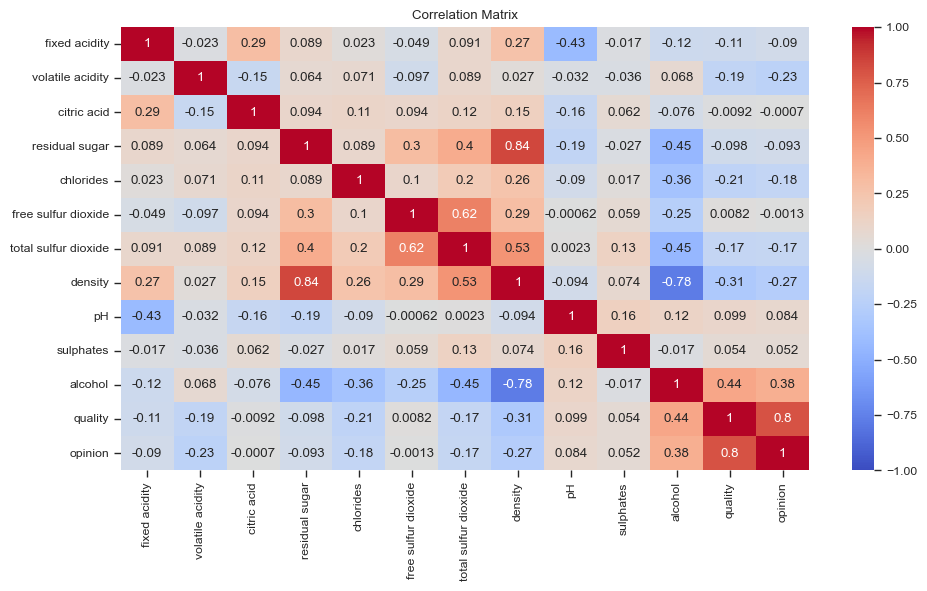

In [530]:
get_info(wine_white)

### Notes: Based on the analysis:
1 - Wine_Red is a smaller data set and higher standard deviation in comparison to white wine

2 - Datasets in this study have no nulls

3 - Column name matches for both datasets.

4 - Nothing seems to show very strong correlation, except for the quality which is the variable we based on to create our classifier

5 - Wine_Red has closer amount for Good and Bad wine, whereas Wine_White has more Good Wines

## Machine Learning Steps:

1 - Select features and targets

2 - Train-Test Split - split the scaled input features (X_scaled) and the target variable (y) into training and test sets using the train_test_split() function. This allows us to evaluate the model’s performance on unseen data and detect overfitting issues.

3 - Feature Scaling - Standardize the input features (X) using the StandardScaler() from scikit-learn. This step ensures that all features have a similar scale, preventing any one feature from dominating the learning process. It enhances performance and stability, allowing fair comparisons between features.

4 - Machine Learning Model Initialization - Create an instance of the machine learning model and assign it to the variable model. This sets up the model’s structure and algorithms for learning patterns from the data

5 - K-fold Cross-Validation - This means the data is divided into equal parts or “folds,” and the model is trained and evaluated multiple times, each time using a different fold as the validation set and the remaining folds as the training set. This process provides a more comprehensive evaluation of the model’s performance by considering multiple subsets of the data.

6 - Model Training and Best Model Selection - During each iteration of the K-fold cross-validation loop, the model is trained on a specific training fold and evaluated on the validation fold. The best model is selected based on the highest R-squared value, which measures how well the model fits the data.

7 - Predictions with Best Model - Once the best model is determined through cross-validation, it is applied to the entire dataset (X_scaled) to generate predictions for the target variable. These predictions are stored in the variable y_pred, and the best model itself is saved in the variable model.

8 - Evaluation Metrics - calculate the R-squared value and root mean-square deviation to evaluate the performance of the best model. These metrics provide insights into how well the model fits the data and makes predictions.

9 - Asses the performance of your model - Use visualization tools to analayse the performance of your model such as prediction vs actual plots, residuals and ROC curves.

## Testing Databases with Different Regression models:
a) Logistic Regression

b) Decision Tree

c) SVM

### Creating functions to be used in future analysis

#### Function to Train multiple models

In [531]:
def get_train_test(X, y, test_size, random_state,**kwargs):
    """
    Method for training multiple models
    """
    X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X.values,
                                                        y.values,
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=y,
                                                        **kwargs)

    return X_train_cv,X_test_cv, y_train_cv,y_test_cv


#### Function to create interpolations for when I want to analyse multiple k-fold

In [532]:
def interpolation(fpr, tpr):
    interp_fpr = np.linspace(0, 1, 100)
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    interp_tpr[0] = 0.
    return interp_fpr, interp_tpr

#### Function to perform cross validation

In [533]:
def train_cv(n, X_train_cv, X_test, y_train_cv, y_test, model_class, **kwargs):
    #The function initializes a StratifiedKFold object called cv with n_splits set to n. 
    # Stratified k-fold cross-validation is a technique that ensures each fold has a similar distribution of target labels.
    cv = StratifiedKFold(n_splits=n) 

    #It creates a figure and a single subplot using plt.subplots(1, 1, figsize=(8, 8)) to visualize the evaluation results.
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    #Several empty lists are initialized to store the results for each fold:
    f1_score_val_list   = []
    f1_score_train_list = []
    fprs_list           = [] # fprs_list: List to store the false positive rates.
    tprs_list           = [] # tprs_list: List to store the true positive rates.
    auc_list            = [] # auc_list: List to store the area under the curve (AUC) scores.
    scaler_list         = [] # scaler_list: List to store the StandardScaler objects used for feature scaling.
    model_list          = []

    X_train_scaled_list = [] # Initialize list to store scaled training data
    y_train_list        = [] # Initialize list to store scaled training data
    X_train_list        = [] # Initialize list to store scaled training data

    precision_list      = []
    sensitivity_list    = []

    #The code enters a loop that iterates over each fold of the cross-validation.
    #For each fold, the training and validation indices are obtained using cv.split(X_train, y_train).
    #This function, cv.split(), takes the training data (X_train) and corresponding labels (y_train) as 
    #input and returns the indices for splitting the data into training and validation sets.
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_cv, y_train_cv)):
        
        #The training and validation data are then extracted from X_train and y_train using the obtained indices.
        X_train = X_train_cv[train_idx]
        y_train = y_train_cv[train_idx]

        X_val = X_train_cv[val_idx]
        y_val = y_train_cv[val_idx]

        #A StandardScaler object called scaler is created and added to scaler_list. 
        # StandardScaler is used to standardize the features by subtracting the mean and scaling to unit variance.
        scaler = StandardScaler()
        scaler_list.append(scaler)
        
        #The training data is scaled using the fit_transform method of scaler, and the validation data is scaled using the transform method.
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled_list.append(X_train_scaled) # Store scaled training data
        X_val_scaled = scaler.transform(X_val)

        X_train_list.append(X_train)
        y_train_list.append(y_train)

        model = model_class(**kwargs)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_train_scaled)
        y_pred_val = model.predict(X_val_scaled)

        sensitivity = 100 *  recall_score(y_val, y_pred_val)
        precision= 100 *  precision_score(y_val, y_pred_val)

        precision_list.append(precision)
        sensitivity_list.append(sensitivity)

        print(f"========================= FOLD {fold} ==========================")

        print(f"The results of this train's F1-Score is {f1_score(y_train, y_pred):.2}")
        print(f"The results of this validation's F1-Score is {f1_score(y_val, y_pred_val):.2}")


        f1_score_val_list.append(f1_score(y_val, y_pred_val))
        f1_score_train_list.append(f1_score(y_train, y_pred))
        model_list.append(model)

        viz = RocCurveDisplay.from_estimator(
            model,
            X_val_scaled,
            y_val,
            ax = ax,
            alpha=0.3,
            lw=1
        )
        interp_fpr, interp_tpr = interpolation(viz.fpr, viz.tpr)
        fprs_list.append(interp_fpr)
        tprs_list.append(interp_tpr)
        auc_list.append(viz.roc_auc) 

    mean_fpr = np.mean(fprs_list, axis=0)
    mean_tpr = np.mean(tprs_list, axis=0)
    mean_auc = np.mean(auc_list)
    std_auc  = np.std(auc_list)
    mean_val = np.mean(f1_score_val_list)
    std_val  = np.std(f1_score_val_list)
    mean_pre = np.mean(precision_list, axis=0)
    mean_sen = np.mean(sensitivity_list, axis=0)
    std_pre  = np.std(precision_list)
    std_sen  = np.std(precision_list)
    mean_f1  = np.mean(f1_score_val_list, axis=0)
    std_f1   = np.std(f1_score_val_list)

    ax.plot(
        mean_fpr,
        mean_tpr,
        color='blue',
        lw=2,
        label=r"Mean ROC (AUC = %.2f $\pm$ %.2f)" %(mean_auc, std_auc)
    )

    ax.plot(np.linspace(0, 1, 100),
            np.linspace(0, 1, 100),
            color='g',
            ls=":",
            lw=0.5)
    ax.legend()

    if fold == n-1:
        print(f"The average F1-Score of the train set is {np.mean(f1_score_train_list): .2} +- {np.std(f1_score_train_list): .2} ")
        print(f"The average F1-Score of the validation set is é {mean_val: .2} +- {std_val: .2} ")
        best_model_idx = np.argmax(f1_score_val_list)
        print(f"The best fold was: {best_model_idx} ")
        best_model = model_list[best_model_idx]

        # Fazer a inferência em Test Data
        best_scaler         = scaler_list[best_model_idx]
        X_test_scaled       = best_scaler.transform(X_test)
        y_pred_test         = model.predict(X_test_scaled)
        X_train_scaled_best = X_train_scaled_list[best_model_idx]
        X_train_best        = X_train_list[best_model_idx]
        y_train_best        = y_train_list[best_model_idx]

        print(f"The F1-Score for the test data is: {f1_score(y_test, y_pred_test):.2} with the best model")

        print('===============================Summary of analysis====================================')
        print(f"The Average F1-Score of this test is {mean_f1:.2f} %")
        print(f"The Deviation of F1-Score is: {std_f1:.2}")
        print(f"The Average sensitivity of this test is {mean_sen:.2f} %")
        print(f"The Deviation of sensitivity is: {std_sen:.2} ")
        print(f"The Average Precision of this model is { mean_pre:.2f} %")
        print(f"The Deviation of Precision is: {std_pre:.2} ")
        print(f"The Average accuracy of this model is {mean_auc:.2f} %")
        print(f"The Deviation of accuracy is: {std_auc:.2} ")
        
    return best_model, best_scaler, X_train_best, y_train_best, X_train_scaled_best, X_test_scaled


In [534]:
class ModelResults:
    def __init__(self, results):
        self.model = results['model']
        self.scaler = results['scaler']
        self.X_train = results['X_train']
        self.X_train_scaled = results['X_train_scaled']
        self.X_test = results['X_test']
        self.X_test_scaled = results['X_test_scaled']
        self.y_train = results['y_train']
        self.y_test = results['y_test']
        self.y_pred = None  # Initialize y_pred attribute as None

    def accuracy_train(self):
        self.y_pred = self.model.predict(self.X_train_scaled)  # Set y_pred attribute
        return accuracy_score(self.y_train, self.y_pred)

    def accuracy_test(self):
        self.y_pred = self.model.predict(self.X_test_scaled)  # Set y_pred attribute
        return accuracy_score(self.y_test, self.y_pred)

    def plot_roc(self, X, y, estimator_name : str = "train", **kwargs):
        y_hat = self.model.predict_proba(X)
        fpr, tpr, thresholds = roc_curve(y, y_hat[:, 1], pos_label=1)
        auc_score = auc(fpr, tpr)

        return RocCurveDisplay(fpr=fpr,
                               tpr=tpr,
                               roc_auc=auc_score,
                               estimator_name = estimator_name).plot(**kwargs)

    def plot_roc_train(self, **kwargs):
        self.plot_roc(self.X_train_scaled, self.y_train, estimator_name="train", **kwargs)

    def plot_roc_test(self, **kwargs):
        self.plot_roc(self.X_test_scaled, self.y_test, estimator_name="test", **kwargs)

    def plot_distribution(self, X, y, ax=None, estimator_name: str = "train", **kwargs):
        y = pd.Series(y)  # Convert y to pandas Series
        y_hat = self.model.predict_proba(X)
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        sns.distplot(y_hat[y.values == 1, 1], label="Good", ax=ax)
        ax.set_xlim([0, 1])
        sns.distplot(y_hat[y.values == 0, 1], label="Bad", ax=ax)
        ax.legend()
        return ax

    def plot_distribution_train(self, **kwargs):
        self.plot_distribution(self.X_train_scaled, self.y_train, estimator_name="train", **kwargs)

    def plot_distribution_test(self, **kwargs):
        self.plot_distribution(self.X_test_scaled, self.y_test, estimator_name="test", **kwargs)

    def correlation_matrix_train(self, **kwargs):
        self.y_pred = self.model.predict(self.X_train_scaled)
        cm = confusion_matrix(self.y_train, self.y_pred)
        ax = sns.heatmap(cm, cmap ="BuGn", annot=True, fmt='g')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix')
        ax.set_xticklabels(['Bad Wine(0)', 'Good Wine(1)'])
        ax.set_yticklabels(['Bad Wine(0)', 'Good Wine(1)'])

    def correlation_matrix_test(self, **kwargs):
        self.y_pred = self.model.predict(self.X_test_scaled)
        cm = confusion_matrix(self.y_test, self.y_pred)
        ax = sns.heatmap(cm, cmap ="BuGn", annot=True, fmt='g')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix')
        ax.set_xticklabels(['Bad Wine(0)', 'Good Wine(1)'])
        ax.set_yticklabels(['Bad Wine(0)', 'Good Wine(1)'])
    
    def get_sensitivity(self, **kwargs):
        self.y_pred = self.model.predict(self.X_test_scaled)
        print(f"The sensitivity of this model is {100 *  recall_score(self.y_test, self.y_pred):.2f} %")

    def get_precision(self, **kwargs):
        self.y_pred = self.model.predict(self.X_test_scaled)
        print(f"The Precision of this model is {100 *  precision_score(self.y_test, self.y_pred):.2f} %")
    

## Test Models

#### Defining variables:

In [535]:
#Defining variables:
X_red = wine_red.drop(['quality', 'opinion'], axis=1)
y_red = wine_red['opinion']

X_white = wine_white.drop(['quality', 'opinion'], axis=1)
y_white = wine_white['opinion']

## Logistic Regression

In [536]:
X_train_red, X_test_red,y_train_red,y_test_red = get_train_test(X_red, y_red, 0.2, 42)


========================= FOLD 0 ==========================
The results of this train's F1-Score is 0.76
The results of this validation's F1-Score is 0.77
========================= FOLD 1 ==========================
The results of this train's F1-Score is 0.76
The results of this validation's F1-Score is 0.74
========================= FOLD 2 ==========================
The results of this train's F1-Score is 0.76
The results of this validation's F1-Score is 0.74
========================= FOLD 3 ==========================
The results of this train's F1-Score is 0.76
The results of this validation's F1-Score is 0.73
========================= FOLD 4 ==========================
The results of this train's F1-Score is 0.77
The results of this validation's F1-Score is 0.74
========================= FOLD 5 ==========================
The results of this train's F1-Score is 0.76
The results of this validation's F1-Score is 0.76
========================= FOLD 6 ==========================
The result

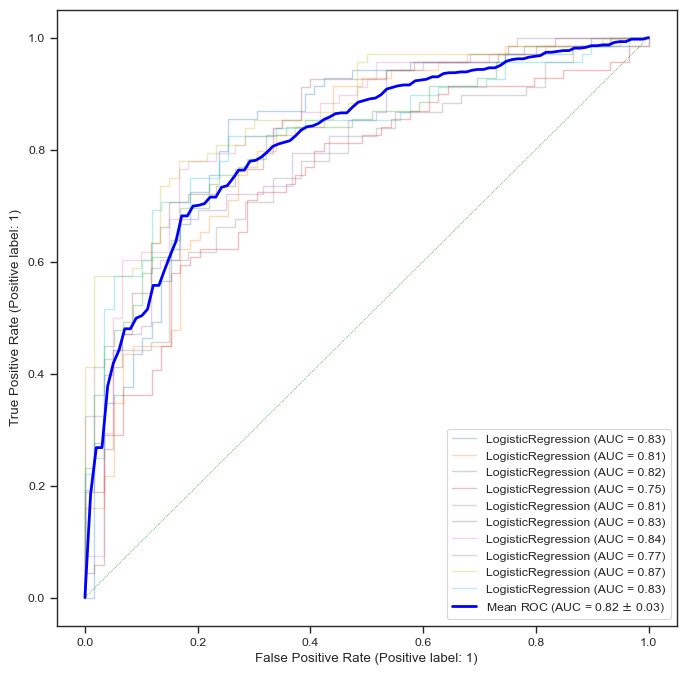

In [537]:
model_log_red, log_red_scaler, X_train_log_red, y_train_log_red, X_train_scaled_log_red, X_test_log_red_scaled = train_cv(10, X_train_red, X_test_red, y_train_red, y_test_red, LogisticRegression, max_iter= 10000)

In [538]:
results_red_log = {
    'model': model_log_red,
    'scaler': log_red_scaler,
    'X_train': X_train_log_red,
    'X_train_scaled': X_train_scaled_log_red,
    'X_test': X_test_red,
    'X_test_scaled': X_test_log_red_scaled,
    'y_train': y_train_log_red,
    'y_test': y_test_red
}

In [539]:
model_results_red_log = ModelResults(results_red_log)

In [540]:
model_results_red_log.__dict__

{'model': LogisticRegression(max_iter=10000),
 'scaler': StandardScaler(),
 'X_train': array([[ 7.3  ,  0.51 ,  0.18 , ...,  3.52 ,  0.73 ,  9.5  ],
        [ 6.7  ,  0.54 ,  0.13 , ...,  3.61 ,  0.64 ,  9.8  ],
        [ 9.1  ,  0.5  ,  0.3  , ...,  3.32 ,  0.71 , 10.5  ],
        ...,
        [ 7.2  ,  0.66 ,  0.03 , ...,  3.53 ,  0.57 ,  9.7  ],
        [ 6.1  ,  0.705,  0.1  , ...,  3.6  ,  0.66 , 10.2  ],
        [ 9.8  ,  0.51 ,  0.19 , ...,  3.23 ,  0.58 , 10.5  ]]),
 'X_train_scaled': array([[-0.59041112, -0.08862182, -0.47448683, ...,  1.36103916,
          0.45585228, -0.88455503],
        [-0.93653839,  0.07993293, -0.73202448, ...,  1.95102972,
         -0.10054854, -0.60627802],
        [ 0.44797068, -0.14480673,  0.14360353, ...,  0.049949  ,
          0.33220765,  0.04303502],
        ...,
        [-0.648099  ,  0.75415191, -1.24709979, ...,  1.42659366,
         -0.53330473, -0.69903702],
        [-1.28266566,  1.00698403, -0.88654707, ...,  1.88547522,
          0.0230

In [541]:
# Checking the dimensions of input arrays
print("Shape of X_train_red:", X_train_log_red.shape)
print("Shape of y_train_red:", y_train_log_red.shape)
print("Shape of X_test_red:", X_test_log_red_scaled.shape)
print("Shape of y_test_red:", y_test_red.shape)
print("Shape of X_train_scaled_red:", X_train_scaled_log_red.shape)

# Verifying consistency in the number of samples
if X_train_red.shape[0] == y_train_red.shape[0]:
    print("Number of samples in X_train_red and y_train_red are consistent.")
else:
    print("Number of samples in X_train_red and y_train_red are inconsistent.")

if X_test_red.shape[0] == y_test_red.shape[0]:
    print("Number of samples in X_test_red and y_test_red are consistent.")
else:
    print("Number of samples in X_test_red and y_test_red are inconsistent.")

Shape of X_train_red: (1151, 11)
Shape of y_train_red: (1151,)
Shape of X_test_red: (320, 11)
Shape of y_test_red: (320,)
Shape of X_train_scaled_red: (1151, 11)
Number of samples in X_train_red and y_train_red are consistent.
Number of samples in X_test_red and y_test_red are consistent.


In [542]:
# Call the methods of ModelResults
train_accuracy_red_log = model_results_red_log.accuracy_train()
test_accuracy_red_log  = model_results_red_log.accuracy_test()
print(f'The train accuracy AUC was {train_accuracy_red_log}')
print(f'The test accuracy AUC was {test_accuracy_red_log}')


The train accuracy AUC was 0.737619461337967
The test accuracy AUC was 0.746875


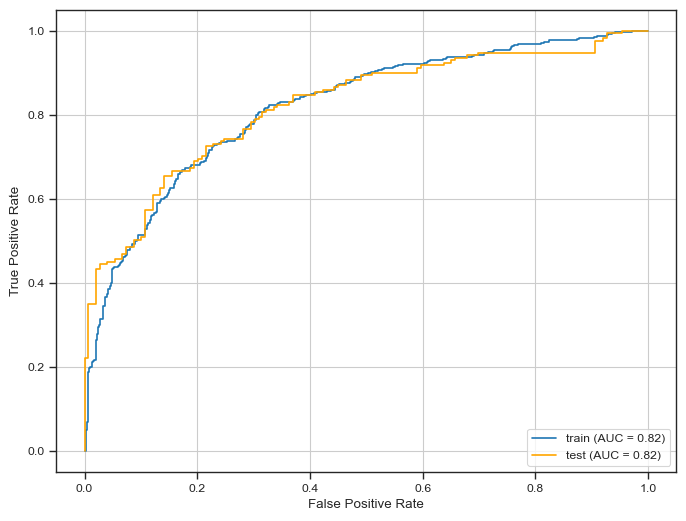

In [543]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

model_results_red_log.plot_roc_train(ax=ax)
model_results_red_log.plot_roc_test(ax=ax, color='orange')
ax.grid()

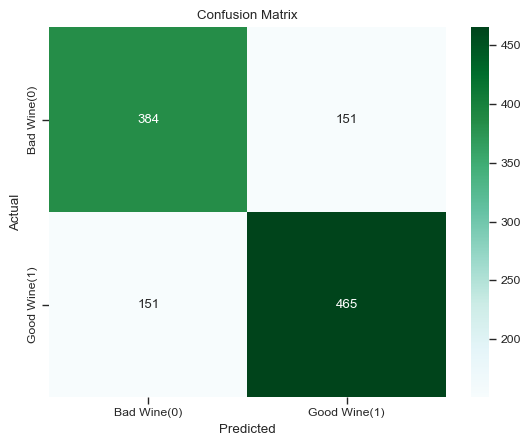

In [544]:
model_results_red_log.correlation_matrix_train()

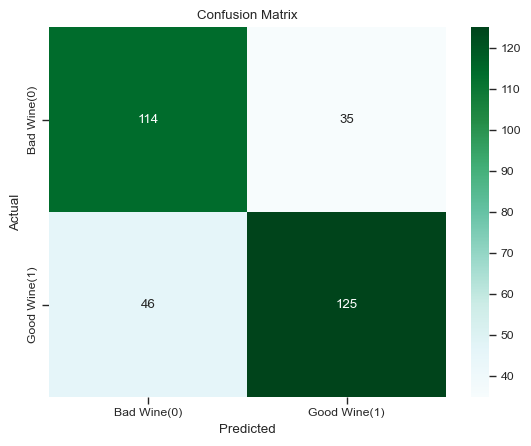

In [545]:
model_results_red_log.correlation_matrix_test()

C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\3721583655.py:42: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_hat[y.values == 1, 1], label="Good", ax=ax)
C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\3721583655.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_hat[y.values == 0, 1

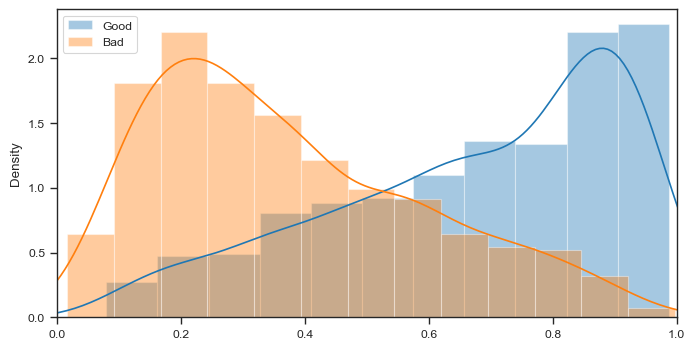

In [546]:
model_results_red_log.plot_distribution_train()

C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\3721583655.py:42: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_hat[y.values == 1, 1], label="Good", ax=ax)
C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\3721583655.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_hat[y.values == 0, 1

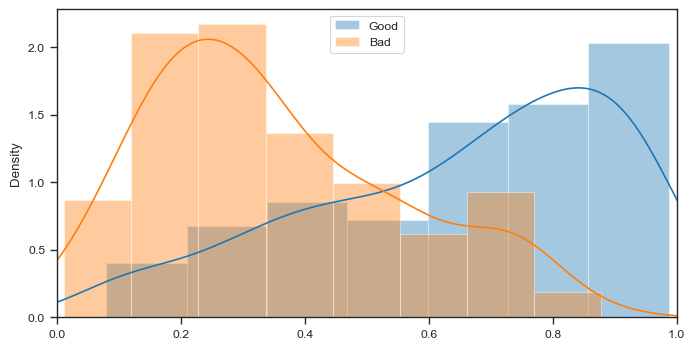

In [547]:
model_results_red_log.plot_distribution_test()

In [548]:
model_results_red_log.get_precision()
model_results_red_log.get_sensitivity()

The Precision of this model is 78.12 %
The sensitivity of this model is 73.10 %


========================= FOLD 0 ==========================
The results of this train's F1-Score is 0.83
The results of this validation's F1-Score is 0.82
========================= FOLD 1 ==========================
The results of this train's F1-Score is 0.83
The results of this validation's F1-Score is 0.83
========================= FOLD 2 ==========================
The results of this train's F1-Score is 0.83
The results of this validation's F1-Score is 0.81
========================= FOLD 3 ==========================
The results of this train's F1-Score is 0.83
The results of this validation's F1-Score is 0.82
========================= FOLD 4 ==========================
The results of this train's F1-Score is 0.83
The results of this validation's F1-Score is 0.84
========================= FOLD 5 ==========================
The results of this train's F1-Score is 0.83
The results of this validation's F1-Score is 0.85
========================= FOLD 6 ==========================
The result

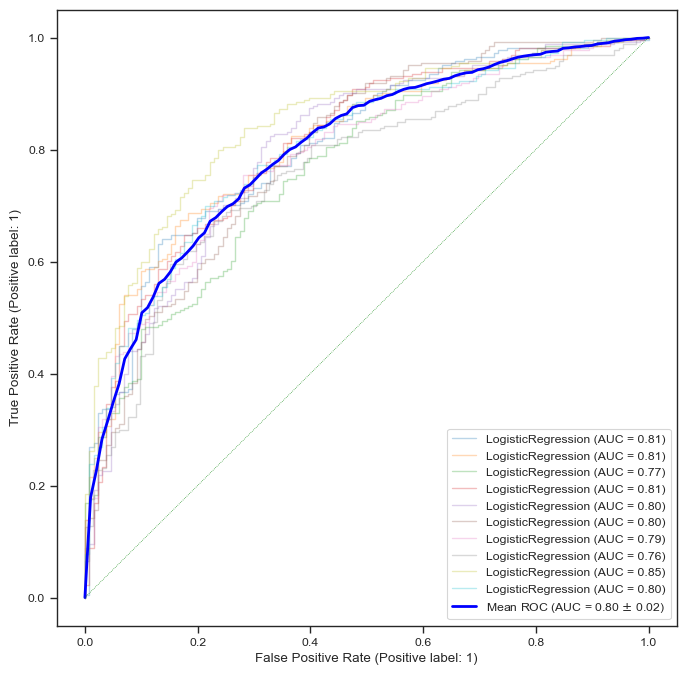

In [549]:
X_train_white, X_test_white,y_train_white,y_test_white = get_train_test(X_white, y_white, 0.2, 42)
model_log_white, log_white_scaler, X_train_log_white, y_train_log_white, X_train_scaled_log_white, X_test_log_white_scaled = train_cv(10, X_train_white, X_test_white, y_train_white, y_test_white, LogisticRegression, max_iter= 10000)

In [550]:
results_white_log = {
    'model': model_log_white,
    'scaler': log_white_scaler,
    'X_train': X_train_log_white,
    'X_train_scaled': X_train_scaled_log_white,
    'X_test': X_test_white,
    'X_test_scaled': X_test_log_white_scaled,
    'y_train': y_train_log_white,
    'y_test': y_test_white
}

In [551]:
model_results_white_log = ModelResults(results_white_log)

In [552]:
model_results_white_log.__dict__

{'model': LogisticRegression(max_iter=10000),
 'scaler': StandardScaler(),
 'X_train': array([[ 6.8 ,  0.26,  0.34, ...,  3.33,  0.53, 12.  ],
        [ 7.4 ,  0.21,  0.8 , ...,  2.95,  0.48,  9.  ],
        [ 6.5 ,  0.19,  0.32, ...,  3.36,  0.54, 10.8 ],
        ...,
        [ 6.6 ,  0.18,  0.35, ...,  3.43,  0.85, 10.2 ],
        [ 6.9 ,  0.19,  0.35, ...,  3.  ,  0.63, 10.7 ],
        [ 6.4 ,  0.28,  0.17, ...,  3.22,  0.46,  9.4 ]]),
 'X_train_scaled': array([[-0.06534433, -0.163417  ,  0.0636113 , ...,  0.94633189,
          0.35215319,  1.2092254 ],
        [ 0.64397436, -0.66552672,  3.92315705, ..., -1.59332646,
         -0.08530958, -1.23983656],
        [-0.42000368, -0.8663706 , -0.10419503, ...,  1.14683123,
          0.43964574,  0.22960062],
        ...,
        [-0.3017839 , -0.96679255,  0.14751447, ...,  1.61466303,
          3.15191491, -0.26021177],
        [ 0.05287545, -0.8663706 ,  0.14751447, ..., -1.25916089,
          1.22707872,  0.14796522],
        [-0.5382

In [553]:
# Checking the dimensions of input arrays
print("Shape of X_train_white:", X_train_log_white.shape)
print("Shape of y_train_white:", y_train_log_white.shape)
print("Shape of X_test_white:", X_test_log_white_scaled.shape)
print("Shape of y_test_white:", y_test_white.shape)
print("Shape of X_train_scaled_white:", X_train_scaled_log_white.shape)

# Verifying consistency in the number of samples
if X_train_white.shape[0] == y_train_white.shape[0]:
    print("Number of samples in X_train_white and y_train_white are consistent.")
else:
    print("Number of samples in X_train_red and y_train_white are inconsistent.")

if X_test_white.shape[0] == y_test_white.shape[0]:
    print("Number of samples in X_test_white and y_test_white are consistent.")
else:
    print("Number of samples in X_test_white and y_test_white are inconsistent.")

Shape of X_train_white: (3527, 11)
Shape of y_train_white: (3527,)
Shape of X_test_white: (980, 11)
Shape of y_test_white: (980,)
Shape of X_train_scaled_white: (3527, 11)
Number of samples in X_train_white and y_train_white are consistent.
Number of samples in X_test_white and y_test_white are consistent.


In [554]:
# Call the methods of ModelResults
train_accuracy = model_results_white_log.accuracy_train()
test_accuracy  = model_results_white_log.accuracy_test()
print(f'The train accuracy AUC was {train_accuracy}')
print(f'The test accuracy AUC was {test_accuracy}')

The train accuracy AUC was 0.7513467536149703
The test accuracy AUC was 0.7438775510204082


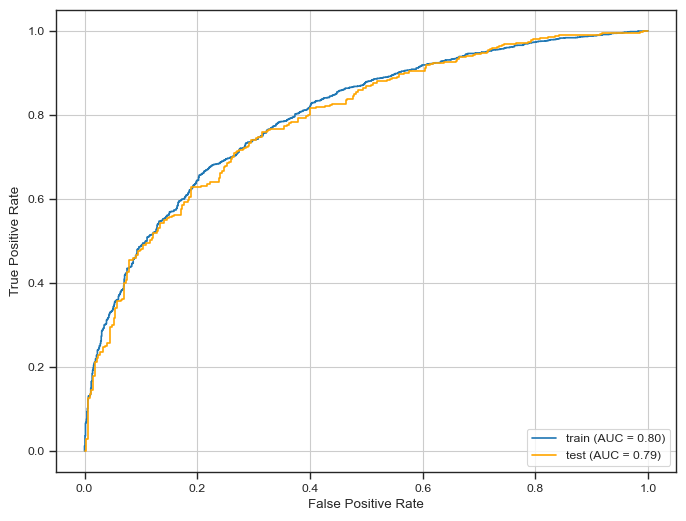

In [555]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

model_results_white_log.plot_roc_train(ax=ax)
model_results_white_log.plot_roc_test(ax=ax, color='orange')
ax.grid()

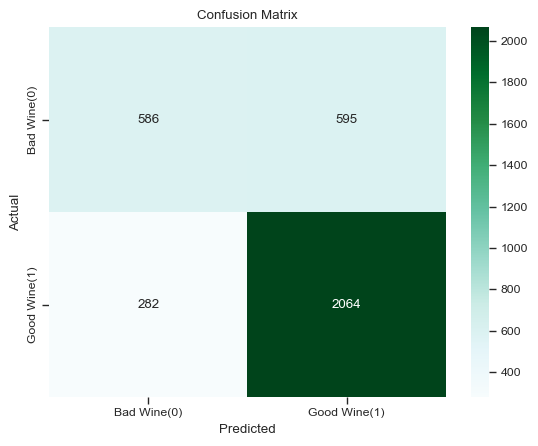

In [556]:
model_results_white_log.correlation_matrix_train()

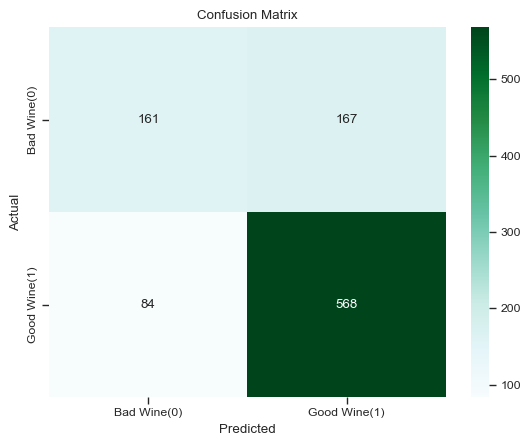

In [557]:
model_results_white_log.correlation_matrix_test()

C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\3721583655.py:42: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_hat[y.values == 1, 1], label="Good", ax=ax)
C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\3721583655.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_hat[y.values == 0, 1

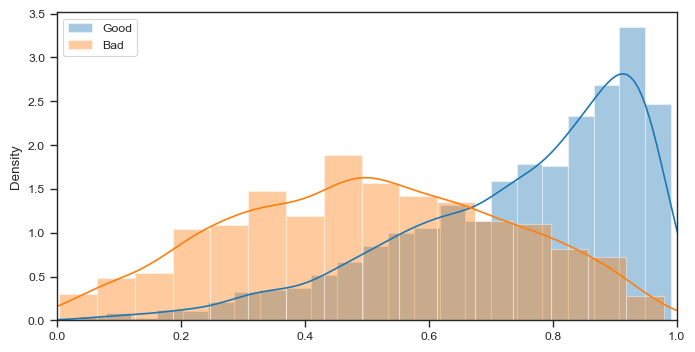

In [558]:
model_results_white_log.plot_distribution_train()

C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\3721583655.py:42: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_hat[y.values == 1, 1], label="Good", ax=ax)
C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\3721583655.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_hat[y.values == 0, 1

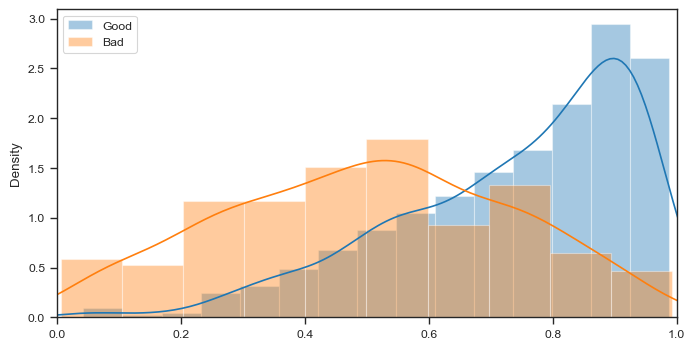

In [559]:
model_results_white_log.plot_distribution_test()

In [560]:
model_results_white_log.get_precision()
model_results_white_log.get_sensitivity()

The Precision of this model is 77.28 %
The sensitivity of this model is 87.12 %


### DECISION TREE

In [561]:
X_train_red, X_test_red,y_train_red,y_test_red = get_train_test(X_red, y_red, 0.2, 42)

========================= FOLD 0 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.7
========================= FOLD 1 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.74
========================= FOLD 2 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.78
========================= FOLD 3 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.78
========================= FOLD 4 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.74
========================= FOLD 5 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.72
========================= FOLD 6 ==========================
The results of th

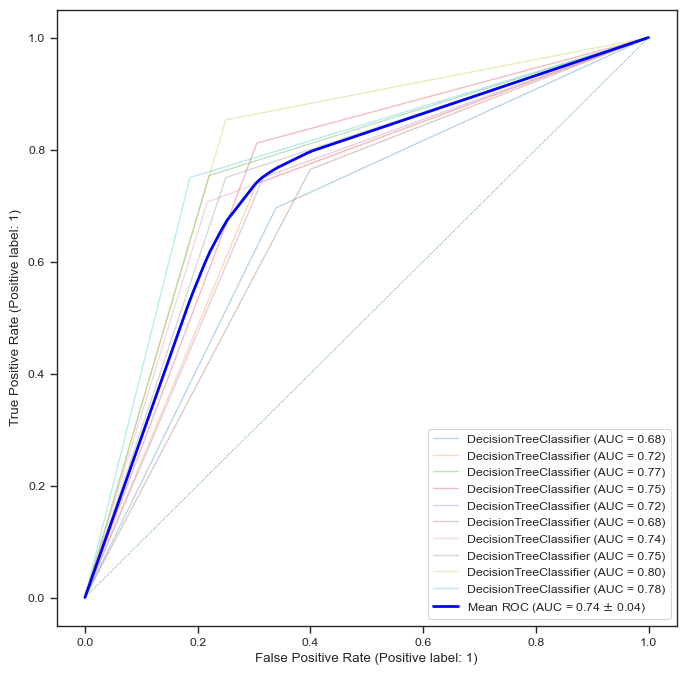

In [562]:
model_dt_red, dt_red_scaler, X_train_dt_red, y_train_dt_red, X_train_scaled_dt_red, X_test_dt_red_scaled = train_cv(10, X_train_red, X_test_red, y_train_red, y_test_red, DecisionTreeClassifier)

In [563]:
results_red_dt = {
    'model': model_dt_red,
    'scaler': dt_red_scaler,
    'X_train': X_train_dt_red,
    'X_train_scaled': X_train_scaled_dt_red,
    'X_test': X_test_red,
    'X_test_scaled': X_test_dt_red_scaled,
    'y_train': y_train_dt_red,
    'y_test': y_test_red
}

In [564]:
model_results_red_dt = ModelResults(results_red_dt)
model_results_red_dt.__dict__

{'model': DecisionTreeClassifier(),
 'scaler': StandardScaler(),
 'X_train': array([[ 7.3  ,  0.51 ,  0.18 , ...,  3.52 ,  0.73 ,  9.5  ],
        [ 6.7  ,  0.54 ,  0.13 , ...,  3.61 ,  0.64 ,  9.8  ],
        [ 9.1  ,  0.5  ,  0.3  , ...,  3.32 ,  0.71 , 10.5  ],
        ...,
        [ 7.2  ,  0.66 ,  0.03 , ...,  3.53 ,  0.57 ,  9.7  ],
        [ 6.1  ,  0.705,  0.1  , ...,  3.6  ,  0.66 , 10.2  ],
        [ 9.8  ,  0.51 ,  0.19 , ...,  3.23 ,  0.58 , 10.5  ]]),
 'X_train_scaled': array([[-0.59445745, -0.08709516, -0.48303559, ...,  1.36406399,
          0.43204166, -0.86451946],
        [-0.94013976,  0.07998239, -0.74307954, ...,  1.95087208,
         -0.11308862, -0.5807026 ],
        [ 0.44258949, -0.14278767,  0.14106989, ...,  0.06004601,
          0.3109016 ,  0.08153673],
        ...,
        [-0.65207117,  0.74829257, -1.26316744, ...,  1.42926489,
         -0.53707883, -0.67530822],
        [-1.28582208,  0.99890889, -0.89910591, ...,  1.88567118,
          0.00805145, -0.2

In [565]:
# Checking the dimensions of input arrays
print("Shape of X_train_red:", X_train_dt_red.shape)
print("Shape of y_train_red:", y_train_dt_red.shape)
print("Shape of X_test_red:", X_test_dt_red_scaled.shape)
print("Shape of y_test_red:", y_test_red.shape)
print("Shape of X_train_scaled_red:", X_train_scaled_dt_red.shape)

# Verifying consistency in the number of samples
if X_train_red.shape[0] == y_train_red.shape[0]:
    print("Number of samples in X_train_red and y_train_red are consistent.")
else:
    print("Number of samples in X_train_red and y_train_red are inconsistent.")

if X_test_red.shape[0] == y_test_red.shape[0]:
    print("Number of samples in X_test_red and y_test_red are consistent.")
else:
    print("Number of samples in X_test_red and y_test_red are inconsistent.")

Shape of X_train_red: (1151, 11)
Shape of y_train_red: (1151,)
Shape of X_test_red: (320, 11)
Shape of y_test_red: (320,)
Shape of X_train_scaled_red: (1151, 11)
Number of samples in X_train_red and y_train_red are consistent.
Number of samples in X_test_red and y_test_red are consistent.


In [566]:
# Call the methods of ModelResults
train_accuracy_red_dt = model_results_red_dt.accuracy_train()
test_accuracy_red_dt  = model_results_red_dt.accuracy_test()
print(f'The train accuracy AUC was {train_accuracy_red_dt}')
print(f'The test accuracy AUC was {test_accuracy_red_dt}')

The train accuracy AUC was 1.0
The test accuracy AUC was 0.73125


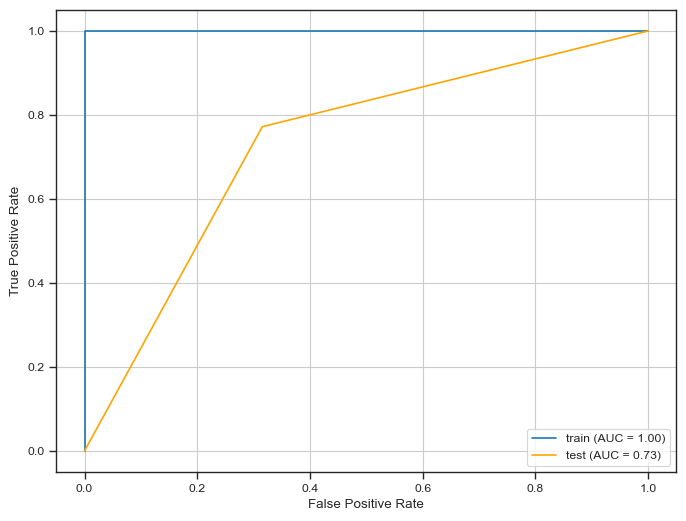

In [567]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

model_results_red_dt.plot_roc_train(ax=ax)
model_results_red_dt.plot_roc_test(ax=ax, color='orange')
ax.grid()

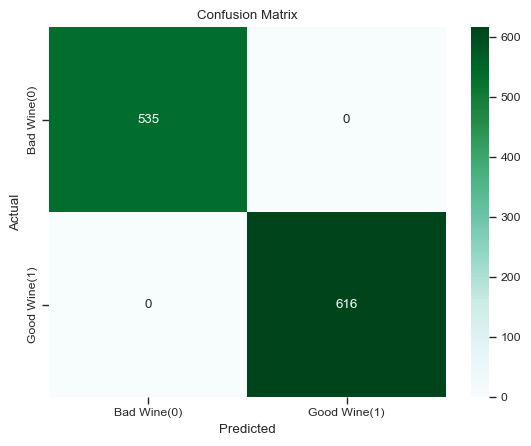

In [568]:
model_results_red_dt.correlation_matrix_train()

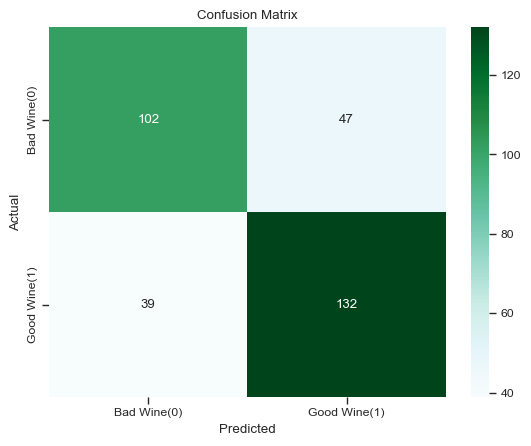

In [569]:
model_results_red_dt.correlation_matrix_test()

In [570]:
model_results_red_dt.get_precision()
model_results_red_dt.get_sensitivity()

The Precision of this model is 73.74 %
The sensitivity of this model is 77.19 %


In [571]:
X_train_white, X_test_white,y_train_white,y_test_white = get_train_test(X_white, y_white, 0.2, 42)

========================= FOLD 0 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.83
========================= FOLD 1 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.84
========================= FOLD 2 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.86
========================= FOLD 3 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.82
========================= FOLD 4 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.86
========================= FOLD 5 ==========================
The results of this train's F1-Score is 1.0
The results of this validation's F1-Score is 0.84
========================= FOLD 6 ==========================
The results of t

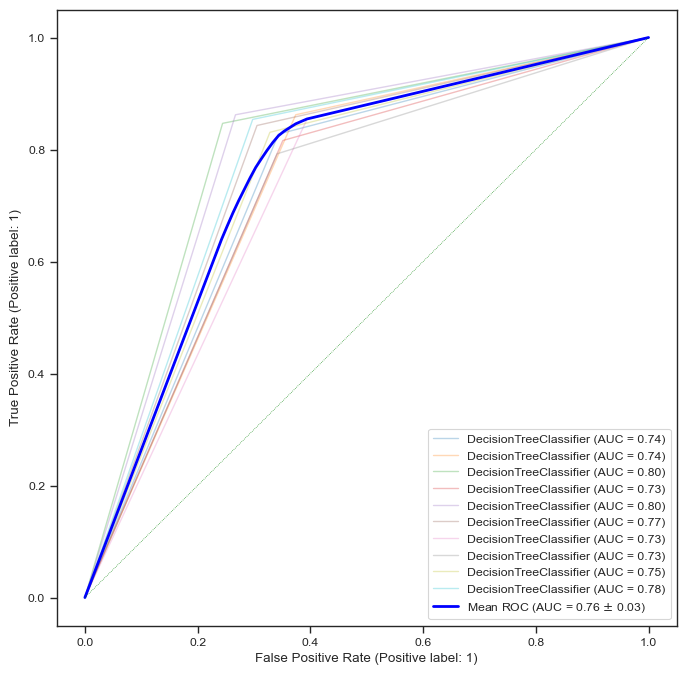

In [572]:
model_dt_white, dt_white_scaler, X_train_dt_white, y_train_dt_white, X_train_scaled_dt_white, X_test_dt_white_scaled = train_cv(10, X_train_white, X_test_white, y_train_white, y_test_white, DecisionTreeClassifier)

In [573]:
results_white_dt = {
    'model': model_dt_white,
    'scaler': dt_white_scaler,
    'X_train': X_train_dt_white,
    'X_train_scaled': X_train_scaled_dt_white,
    'X_test': X_test_white,
    'X_test_scaled': X_test_dt_white_scaled,
    'y_train': y_train_dt_white,
    'y_test': y_test_white
}

In [574]:
model_results_white_dt = ModelResults(results_white_dt)
model_results_white_dt.__dict__

{'model': DecisionTreeClassifier(),
 'scaler': StandardScaler(),
 'X_train': array([[ 6.8 ,  0.26,  0.34, ...,  3.33,  0.53, 12.  ],
        [ 7.4 ,  0.21,  0.8 , ...,  2.95,  0.48,  9.  ],
        [ 6.5 ,  0.19,  0.32, ...,  3.36,  0.54, 10.8 ],
        ...,
        [ 6.6 ,  0.18,  0.35, ...,  3.43,  0.85, 10.2 ],
        [ 6.9 ,  0.19,  0.35, ...,  3.  ,  0.63, 10.7 ],
        [ 6.4 ,  0.28,  0.17, ...,  3.22,  0.46,  9.4 ]]),
 'X_train_scaled': array([[-0.07754521, -0.17842208,  0.04863295, ...,  0.94039773,
          0.34897093,  1.22122682],
        [ 0.62973931, -0.67242778,  3.84279841, ..., -1.5795921 ,
         -0.08857672, -1.23285459],
        [-0.43118747, -0.87003005, -0.11633077, ...,  1.1393443 ,
          0.43648046,  0.23959426],
        ...,
        [-0.31330672, -0.96883119,  0.13111481, ...,  1.60355295,
          3.14927588, -0.25122203],
        [ 0.04033554, -0.87003005,  0.13111481, ..., -1.24801449,
          1.22406623,  0.15779154],
        [-0.54906822,  0.0

In [575]:
# Checking the dimensions of input arrays
print("Shape of X_train_white:", X_train_dt_white.shape)
print("Shape of y_train_white:", y_train_dt_white.shape)
print("Shape of X_test_white:", X_test_dt_white_scaled.shape)
print("Shape of y_test_white:", y_test_white.shape)
print("Shape of X_train_scaled_white:", X_train_scaled_dt_white.shape)

# Verifying consistency in the number of samples
if X_train_white.shape[0] == y_train_white.shape[0]:
    print("Number of samples in X_train_white and y_train_white are consistent.")
else:
    print("Number of samples in X_train_white and y_train_white are inconsistent.")

if X_test_white.shape[0] == y_test_white.shape[0]:
    print("Number of samples in X_test_white and y_test_white are consistent.")
else:
    print("Number of samples in X_test_white and y_test_white are inconsistent.")

Shape of X_train_white: (3526, 11)
Shape of y_train_white: (3526,)
Shape of X_test_white: (980, 11)
Shape of y_test_white: (980,)
Shape of X_train_scaled_white: (3526, 11)
Number of samples in X_train_white and y_train_white are consistent.
Number of samples in X_test_white and y_test_white are consistent.


In [576]:
# Call the methods of ModelResults
train_accuracy_white_dt = model_results_white_dt.accuracy_train()
test_accuracy_white_dt  = model_results_white_dt.accuracy_test()
print(f'The train accuracy AUC was {train_accuracy_white_dt }')
print(f'The test accuracy AUC was {test_accuracy_white_dt }')

The train accuracy AUC was 1.0
The test accuracy AUC was 0.7928571428571428


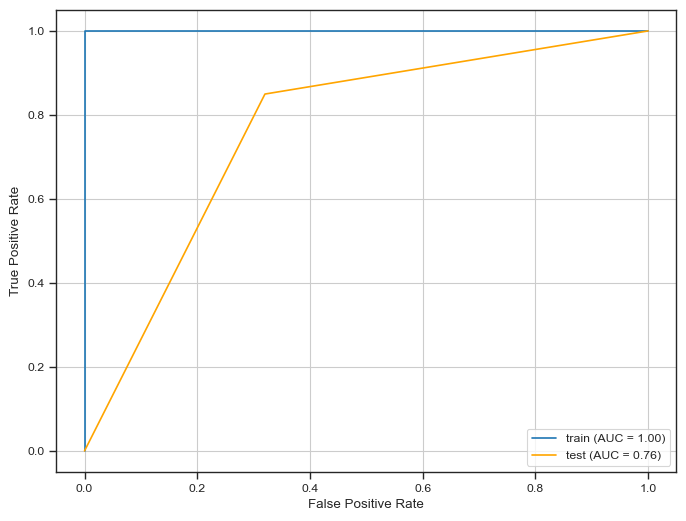

In [577]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

model_results_white_dt.plot_roc_train(ax=ax)
model_results_white_dt.plot_roc_test(ax=ax, color='orange')
ax.grid()

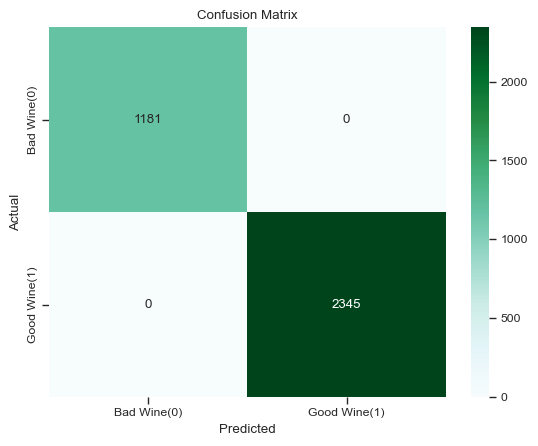

In [578]:
model_results_white_dt.correlation_matrix_train()

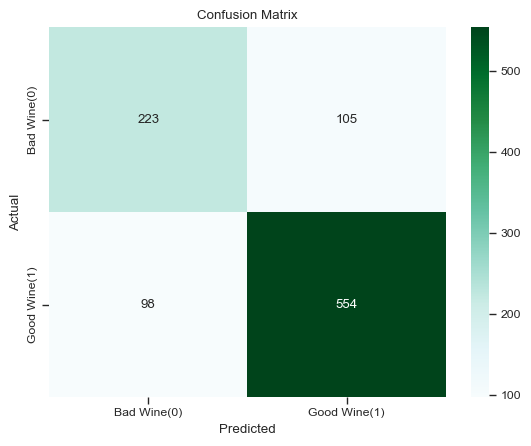

In [579]:
model_results_white_dt.correlation_matrix_test()

In [580]:
model_results_white_dt.get_precision()
model_results_white_dt.get_sensitivity()

The Precision of this model is 84.07 %
The sensitivity of this model is 84.97 %


## SVM MODEL

========================= FOLD 0 ==========================
The results of this train's F1-Score is 0.8
The results of this validation's F1-Score is 0.79
========================= FOLD 1 ==========================
The results of this train's F1-Score is 0.81
The results of this validation's F1-Score is 0.76
========================= FOLD 2 ==========================
The results of this train's F1-Score is 0.81
The results of this validation's F1-Score is 0.8
========================= FOLD 3 ==========================
The results of this train's F1-Score is 0.81
The results of this validation's F1-Score is 0.77
========================= FOLD 4 ==========================
The results of this train's F1-Score is 0.81
The results of this validation's F1-Score is 0.75
========================= FOLD 5 ==========================
The results of this train's F1-Score is 0.81
The results of this validation's F1-Score is 0.79
========================= FOLD 6 ==========================
The results 

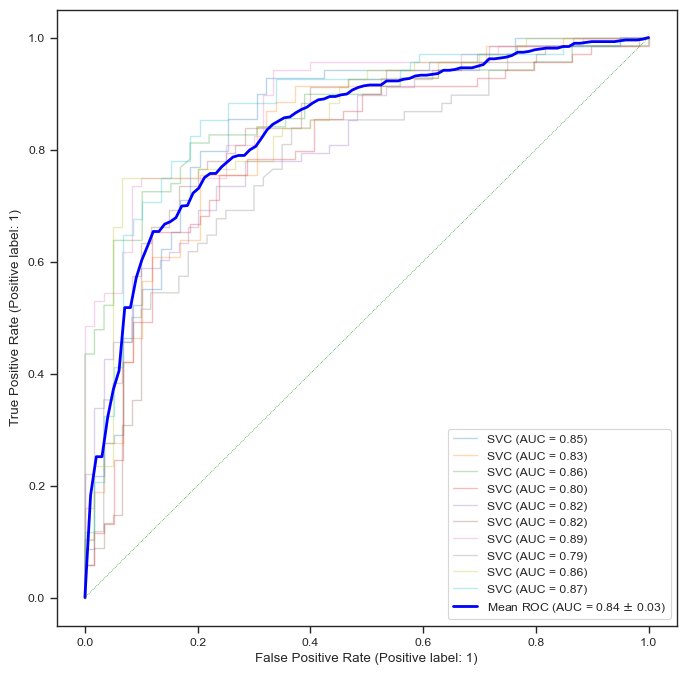

In [581]:
X_train_red, X_test_red,y_train_red,y_test_red = get_train_test(X_red, y_red, 0.2, 42)
model_svm_red, svm_red_scaler, X_train_svm_red, y_train_svm_red, X_train_scaled_svm_red, X_test_svm_red_scaled = train_cv(10, X_train_red, X_test_red, y_train_red, y_test_red, SVC,probability=True, gamma ='auto', C= 1, kernel = 'rbf')

In [582]:
results_red_svm = {
    'model': model_svm_red,
    'scaler': svm_red_scaler,
    'X_train': X_train_svm_red,
    'X_train_scaled': X_train_scaled_svm_red,
    'X_test': X_test_red,
    'X_test_scaled': X_test_svm_red_scaled,
    'y_train': y_train_svm_red,
    'y_test': y_test_red
}

In [583]:
model_results_red_svm = ModelResults(results_red_svm)
model_results_red_svm.__dict__

{'model': SVC(C=1, gamma='auto', probability=True),
 'scaler': StandardScaler(),
 'X_train': array([[ 7.3 ,  0.51,  0.18, ...,  3.52,  0.73,  9.5 ],
        [ 6.7 ,  0.54,  0.13, ...,  3.61,  0.64,  9.8 ],
        [ 9.1 ,  0.5 ,  0.3 , ...,  3.32,  0.71, 10.5 ],
        ...,
        [ 6.  ,  0.49,  0.  , ...,  3.58,  0.59, 12.5 ],
        [12.6 ,  0.41,  0.54, ...,  3.21,  0.76, 11.3 ],
        [ 7.3 ,  0.67,  0.02, ...,  3.32,  0.68, 11.1 ]]),
 'X_train_scaled': array([[-0.58496705, -0.08991441, -0.4783942 , ...,  1.3493239 ,
          0.44154402, -0.87926927],
        [-0.92394192,  0.07769303, -0.73727719, ...,  1.93545555,
         -0.1046178 , -0.59907921],
        [ 0.43195756, -0.14578355,  0.14292499, ...,  0.04680912,
          0.32017473,  0.0546976 ],
        ...,
        [-1.3194126 , -0.2016527 , -1.41037298, ...,  1.74007833,
         -0.40804104,  1.92263132],
        [ 2.40931097, -0.64860587,  1.38556336, ..., -0.669574  ,
          0.62359796,  0.80187109],
        [-

In [584]:
# Checking the dimensions of input arrays
print("Shape of X_train_red:", X_train_svm_red.shape)
print("Shape of y_train_red:", y_train_svm_red.shape)
print("Shape of X_test_red:", X_test_svm_red_scaled.shape)
print("Shape of y_test_red:", y_test_red.shape)
print("Shape of X_train_scaled_red:", X_train_scaled_svm_red.shape)

# Verifying consistency in the number of samples
if X_train_red.shape[0] == y_train_red.shape[0]:
    print("Number of samples in X_train_red and y_train_red are consistent.")
else:
    print("Number of samples in X_train_red and y_train_red are inconsistent.")

if X_test_red.shape[0] == y_test_red.shape[0]:
    print("Number of samples in X_test_red and y_test_red are consistent.")
else:
    print("Number of samples in X_test_red and y_test_red are inconsistent.")

Shape of X_train_red: (1152, 11)
Shape of y_train_red: (1152,)
Shape of X_test_red: (320, 11)
Shape of y_test_red: (320,)
Shape of X_train_scaled_red: (1152, 11)
Number of samples in X_train_red and y_train_red are consistent.
Number of samples in X_test_red and y_test_red are consistent.


In [585]:
# Call the methods of ModelResults
train_accuracy_red_svm = model_results_red_svm.accuracy_train()
test_accuracy_red_svm  = model_results_red_svm.accuracy_test()
print(f'The train accuracy AUC was {train_accuracy_red_svm}')
print(f'The test accuracy AUC was {test_accuracy_red_svm}')

The train accuracy AUC was 0.7899305555555556
The test accuracy AUC was 0.75625


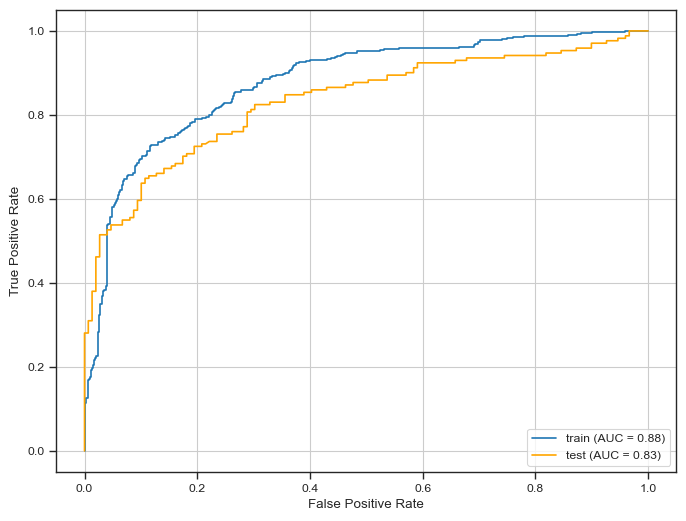

In [586]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

model_results_red_svm.plot_roc_train(ax=ax)
model_results_red_svm.plot_roc_test(ax=ax, color='orange')
ax.grid()

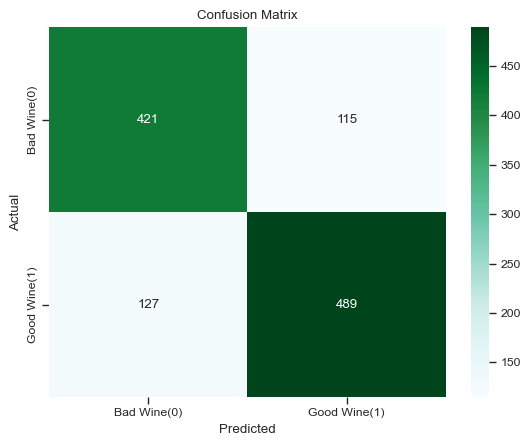

In [587]:
model_results_red_svm.correlation_matrix_train()

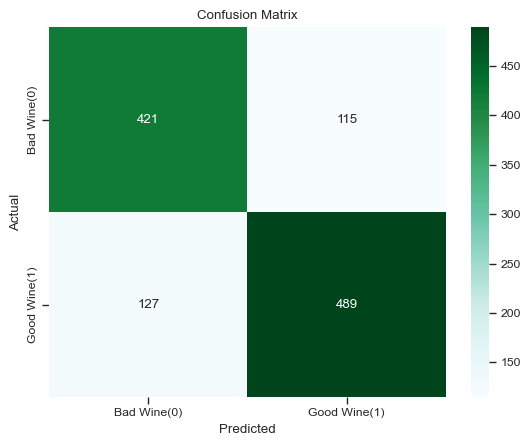

In [588]:
model_results_red_svm.correlation_matrix_train()

In [589]:
model_results_red_svm.get_precision()
model_results_red_svm.get_sensitivity()

The Precision of this model is 80.00 %
The sensitivity of this model is 72.51 %


========================= FOLD 0 ==========================
The results of this train's F1-Score is 0.86
The results of this validation's F1-Score is 0.84
========================= FOLD 1 ==========================
The results of this train's F1-Score is 0.86
The results of this validation's F1-Score is 0.84
========================= FOLD 2 ==========================
The results of this train's F1-Score is 0.86
The results of this validation's F1-Score is 0.83
========================= FOLD 3 ==========================
The results of this train's F1-Score is 0.86
The results of this validation's F1-Score is 0.84
========================= FOLD 4 ==========================
The results of this train's F1-Score is 0.86
The results of this validation's F1-Score is 0.85
========================= FOLD 5 ==========================
The results of this train's F1-Score is 0.86
The results of this validation's F1-Score is 0.86
========================= FOLD 6 ==========================
The result

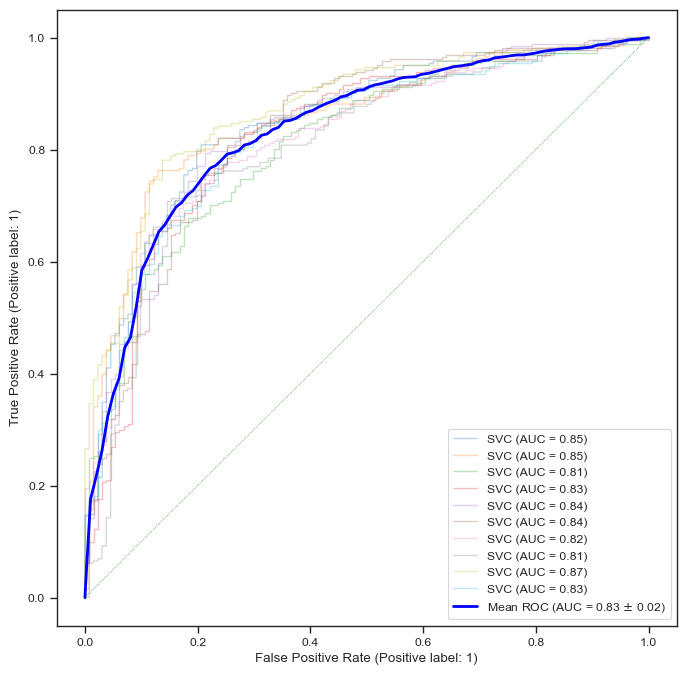

In [590]:
X_train_white, X_test_white,y_train_white,y_test_white = get_train_test(X_white, y_white, 0.2, 42)
model_svm_white, svm_white_scaler, X_train_svm_white, y_train_svm_white, X_train_scaled_svm_white, X_test_svm_white_scaled = train_cv(10, X_train_white, X_test_white, y_train_white, y_test_white, SVC, probability=True, gamma ='auto', C= 1, kernel = 'rbf')

In [591]:
results_white_svm = {
    'model': model_svm_white,
    'scaler': svm_white_scaler,
    'X_train': X_train_svm_white,
    'X_train_scaled': X_train_scaled_svm_white,
    'X_test': X_test_white,
    'X_test_scaled': X_test_svm_white_scaled,
    'y_train': y_train_svm_white,
    'y_test': y_test_white
}

In [592]:
model_results_white_svm = ModelResults(results_white_svm)
model_results_white_svm.__dict__

{'model': SVC(C=1, gamma='auto', probability=True),
 'scaler': StandardScaler(),
 'X_train': array([[ 6.8 ,  0.26,  0.34, ...,  3.33,  0.53, 12.  ],
        [ 7.4 ,  0.21,  0.8 , ...,  2.95,  0.48,  9.  ],
        [ 6.5 ,  0.19,  0.32, ...,  3.36,  0.54, 10.8 ],
        ...,
        [ 6.6 ,  0.18,  0.35, ...,  3.43,  0.85, 10.2 ],
        [ 6.9 ,  0.19,  0.35, ...,  3.  ,  0.63, 10.7 ],
        [ 6.4 ,  0.28,  0.17, ...,  3.22,  0.46,  9.4 ]]),
 'X_train_scaled': array([[-0.0729807 , -0.16816186,  0.05635951, ...,  0.92453631,
          0.34258948,  1.21635762],
        [ 0.63219385, -0.66815236,  3.89723635, ..., -1.57348287,
         -0.09428954, -1.2292244 ],
        [-0.42556798, -0.86814856, -0.11063514, ...,  1.12174835,
          0.42996528,  0.23812481],
        ...,
        [-0.30803888, -0.96814666,  0.13985683, ...,  1.58190978,
          3.13861521, -0.25099159],
        [ 0.04454839, -0.86814856,  0.13985683, ..., -1.24479613,
          1.21634752,  0.15660541],
        [-

In [593]:
# Checking the dimensions of input arrays
print("Shape of X_train_white:", X_train_svm_white.shape)
print("Shape of y_train_white:", y_train_svm_white.shape)
print("Shape of X_test_white:", X_test_svm_white_scaled.shape)
print("Shape of y_test_white:", y_test_white.shape)
print("Shape of X_train_scaled_white:", X_train_scaled_dt_white.shape)

# Verifying consistency in the number of samples
if X_train_white.shape[0] == y_train_white.shape[0]:
    print("Number of samples in X_train_white and y_train_white are consistent.")
else:
    print("Number of samples in X_train_white and y_train_white are inconsistent.")

if X_test_white.shape[0] == y_test_white.shape[0]:
    print("Number of samples in X_test_white and y_test_white are consistent.")
else:
    print("Number of samples in X_test_white and y_test_white are inconsistent.")

Shape of X_train_white: (3526, 11)
Shape of y_train_white: (3526,)
Shape of X_test_white: (980, 11)
Shape of y_test_white: (980,)
Shape of X_train_scaled_white: (3526, 11)
Number of samples in X_train_white and y_train_white are consistent.
Number of samples in X_test_white and y_test_white are consistent.


In [594]:
# Call the methods of ModelResults
train_accuracy_white_svm = model_results_white_svm.accuracy_train()
test_accuracy_white_svm  = model_results_white_svm.accuracy_test()
print(f'The train accuracy AUC was {train_accuracy_white_svm}')
print(f'The test accuracy AUC was {test_accuracy_white_svm}')

The train accuracy AUC was 0.8079977311401021
The test accuracy AUC was 0.7744897959183673


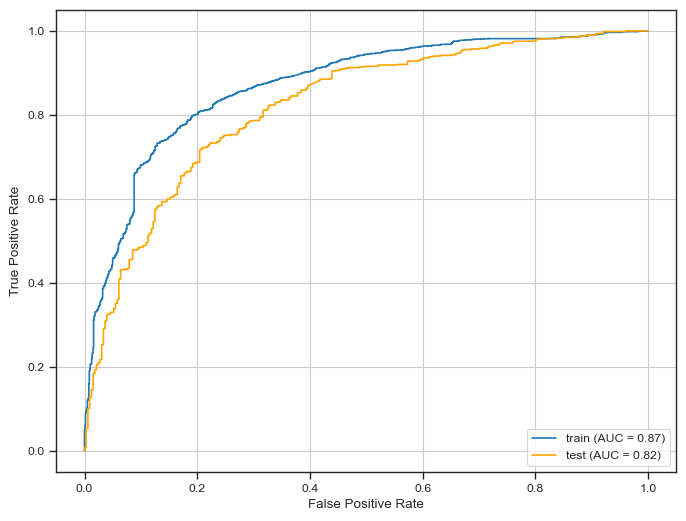

In [595]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

model_results_white_svm.plot_roc_train(ax=ax)
model_results_white_svm.plot_roc_test(ax=ax, color='orange')
ax.grid()

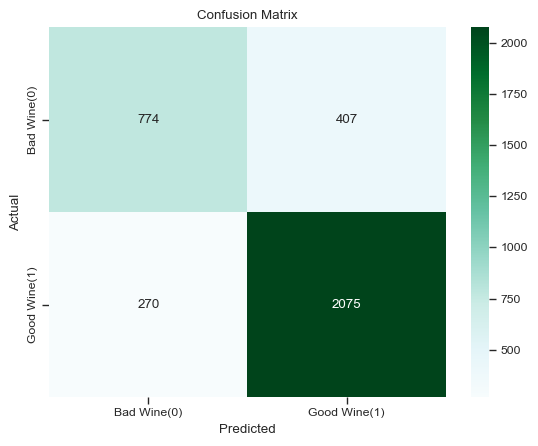

In [596]:
model_results_white_svm.correlation_matrix_train()

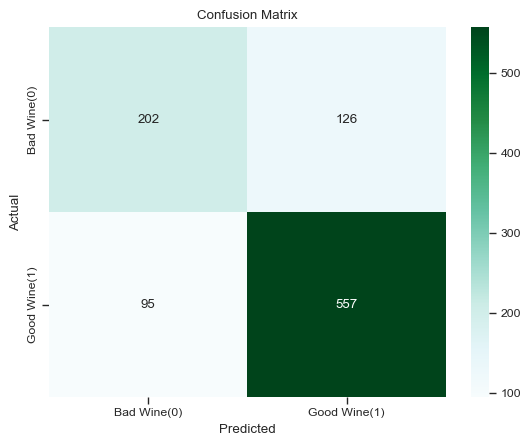

In [597]:
model_results_white_svm.correlation_matrix_test()

In [598]:
model_results_white_svm.get_precision()
model_results_white_svm.get_sensitivity()

The Precision of this model is 81.55 %
The sensitivity of this model is 85.43 %


## Overall Comparison Between Models

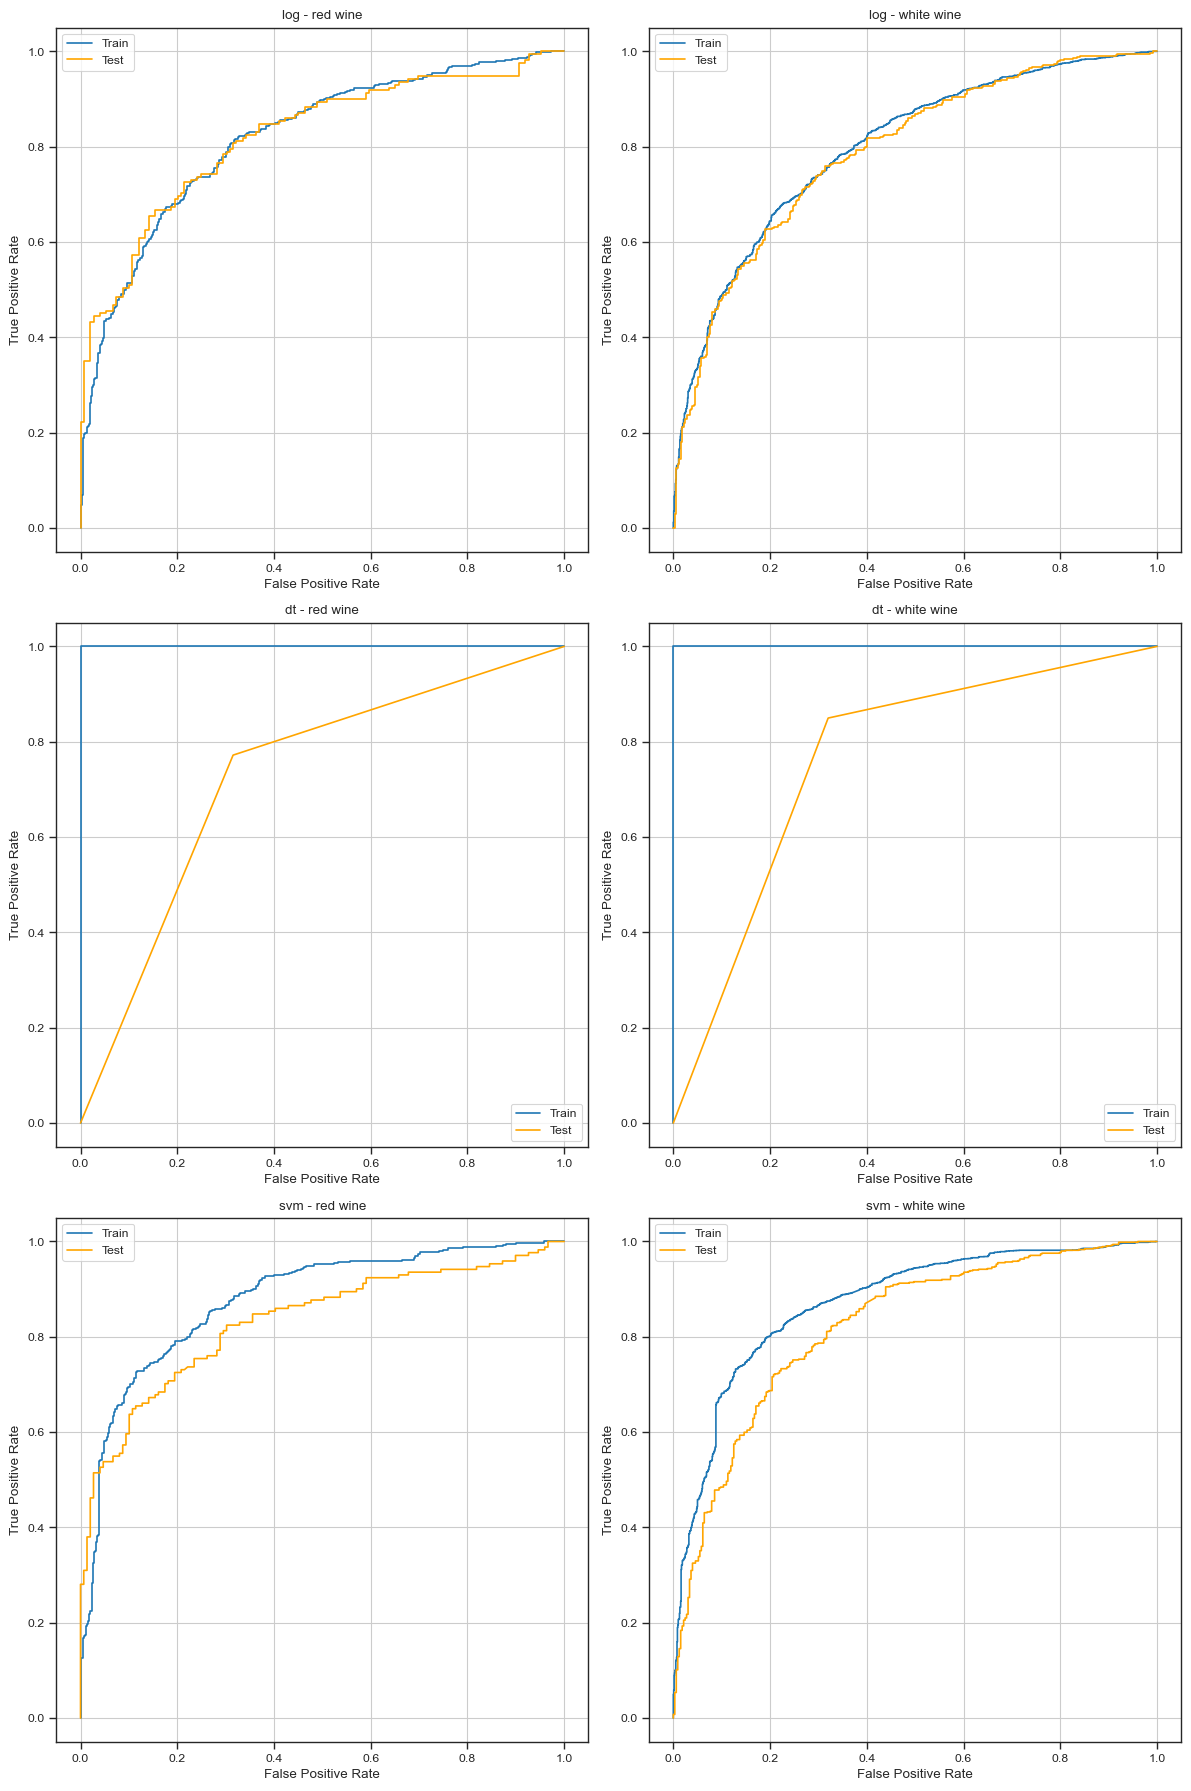

In [599]:
models = [
    ('log', 'red', model_results_red_log),
    ('log', 'white', model_results_white_log),
    ('dt', 'red', model_results_red_dt),
    ('dt', 'white', model_results_white_dt),
    ('svm', 'red', model_results_red_svm),
    ('svm', 'white', model_results_white_svm)
]

fig, axs = plt.subplots(3, 2, figsize=(12, 18))

for i, (model_name, wine_type, model) in enumerate(models):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    model.plot_roc_train(ax=ax)
    model.plot_roc_test(ax=ax, color='orange')
    
    ax.grid()
    ax.set_title(f'{model_name} - {wine_type} wine')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(['Train', 'Test'])

plt.tight_layout()
plt.show()

In [600]:

models = [
    ('log', 'red', model_results_red_log),
    ('log', 'white', model_results_white_log),
    ('dt', 'red', model_results_red_dt),
    ('dt', 'white', model_results_white_dt),
    ('svm', 'red', model_results_red_svm),
    ('svm', 'white', model_results_white_svm)
]

# Create an empty DataFrame to store the statistics
statistics_df = pd.DataFrame(columns=['Model', 'Wine Type', 'Precision', 'Accuracy', 'Sensitivity', 'F1-Score'])

# Iterate over the models and calculate the statistics
for model_name, wine_type, model in models:
    y_train_pred = model.model.predict(model.X_train_scaled)
    y_test_pred = model.model.predict(model.X_test_scaled)
    
    precision_train = precision_score(model.y_train, y_train_pred)
    precision_test = precision_score(model.y_test, y_test_pred)
    
    accuracy_train = accuracy_score(model.y_train, y_train_pred)
    accuracy_test = accuracy_score(model.y_test, y_test_pred)
    
    sensitivity_train = recall_score(model.y_train, y_train_pred)
    sensitivity_test = recall_score(model.y_test, y_test_pred)
    
    f1_score_train = f1_score(model.y_train, y_train_pred)
    f1_score_test = f1_score(model.y_test, y_test_pred)
    
    statistics_df = statistics_df.append({
        'Model': model_name,
        'Wine Type': wine_type,
        'Precision': f"{precision_train:.4f} / {precision_test:.4f}",
        'Accuracy': f"{accuracy_train:.4f} / {accuracy_test:.4f}",
        'Sensitivity': f"{sensitivity_train:.4f} / {sensitivity_test:.4f}",
        'F1-Score': f"{f1_score_train:.4f} / {f1_score_test:.4f}"
    }, ignore_index=True)

# Display the statistics table
statistics_df

C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\973828479.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append({
C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\973828479.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append({
C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\973828479.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append({
C:\Users\apmle\AppData\Local\Temp\ipykernel_21412\973828479.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append({
C:\Users\apmle\AppData\Local\Temp\ip

,Model,Wine Type,Precision,Accuracy,Sensitivity,F1-Score
0,log,red,0.7549 / 0.7812,0.7376 / 0.7469,0.7549 / 0.7310,0.7549 / 0.7553
1,log,white,0.7762 / 0.7728,0.7513 / 0.7439,0.8798 / 0.8712,0.8248 / 0.8190
2,dt,red,1.0000 / 0.7374,1.0000 / 0.7312,1.0000 / 0.7719,1.0000 / 0.7543
3,dt,white,1.0000 / 0.8407,1.0000 / 0.7929,1.0000 / 0.8497,1.0000 / 0.8452
4,svm,red,0.8096 / 0.8000,0.7899 / 0.7562,0.7938 / 0.7251,0.8016 / 0.7607
5,svm,white,0.8360 / 0.8155,0.8080 / 0.7745,0.8849 / 0.8543,0.8597 / 0.8345


#### The Decision Tree model achieves perfect scores on both F1-score and sensitivity on the train set, which suggests that it has learned the training data extremely well. However, when applied to the unseen test data, its performance decreases significantly. This drop in performance indicates that the model may have memorized the training data instead of learning general patterns, resulting in overfitting. Therefore, considering the discrepancy between the performance of the Decision Tree model on the train and test sets, it is likely that the model is overfitted to the training data. 

#### For both red and white wines, the svm model outperforms the logistic regression model in terms of F1-score and sensitivity. This indicates that the svm model has a better balance between precision and recall, making it more effective in correctly identifying positive instances (good wines) while minimizing false negatives (misclassifying good wines as bad).

#### Additionally, the svm model consistently achieves higher precision, accuracy, and sensitivity values compared to the logistic regression model. This indicates that the svm model has a better overall performance in correctly classifying the wines.

#### Furthermore, the svm model demonstrates more stable and reliable performance across different wine types (red and white) compared to the logistic regression model. This suggests that the svm model is more robust and capable of generalizing well to different datasets.

#### Taking all these factors into consideration, it is advisable to choose the svm model over the logistic regression model, as it consistently shows superior performance in terms of F1-score, sensitivity, precision, accuracy, and robustness across different wine types.